In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Allows for easier exploration of the dataset 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

With this data set I will be creating a feature that generates reccomendations for a users music playlist on the Spotify App.


Data Cleaning/Exploration:

In [3]:
df_spotify = pd.read_csv('data_o.csv')

In [4]:
df_spotify.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

1. The data contains a lot of numerical values which I can take advantage of to categorize the music and compare tracks. 

2. One Hot Encoding will be useful with some of the data attributes to make processing the categorical data easier.

3. I could likely compare this data with genre data set that could allow me to find more useful contextual information.

In [5]:
df_genre = pd.read_csv('data_w_genres.csv')

In [6]:
df_genre.head()

artists  acousticness  \
0                   "Cats" 1981 Original London Cast      0.575083   
1                          "Cats" 1983 Broadway Cast      0.862538   
2        "Fiddler On The Roof” Motion Picture Chorus      0.856571   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.884926   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.605444   

   danceability    duration_ms    energy  instrumentalness  liveness  \
0      0.442750  247260.000000  0.386336          0.022717  0.287708   
1      0.441731  287280.000000  0.406808          0.081158  0.315215   
2      0.348286  328920.000000  0.286571          0.024593  0.325786   
3      0.425074  262890.962963  0.245770          0.073587  0.275481   
4      0.437333  232428.111111  0.429333          0.037534  0.216111   

    loudness  speechiness       tempo   valence  popularity  key  mode  count  \
0 -14.205417     0.180675  115.983500  0.334433   38.000000    5     1     12   
1 -10.690000     0.176212  103.044154  0.268865   33.076923    5     1     26   
2 -15.230714     0.118514   77.375857  0.354857   34.285714    0     1      7   
3 -15.639370     0.123200   88.667630  0.372030   34.444444    0     1     27   
4 -11.447222     0.086000  120.329667  0.458667   42.555556   11     1      9   

           genres  
0  ['show tunes']  
1              []  
2              []  
3              []  
4              []

In [7]:
df_genre['genres'].values[0]

"['show tunes']"

In [8]:
df_genre['genres'].values[0][0]

'['

In [9]:
df_genre['genres_new'] = df_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [10]:
df_genre['genres_new'].values[0][0]

'show_tunes'

In [11]:

df_spotify['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [12]:
df_spotify['artists'].values[0][0]

'['

I will need to extract artists names from the string list as shown above

In [13]:
df_spotify['artists_v2'] = df_spotify['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [14]:
df_spotify['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [15]:
df_spotify[df_spotify['artists_v2'].apply(lambda x: not x)].head(5)

valence  year  acousticness                             artists  \
143    0.300  1921         0.772                ["Scarlet D'Carpio"]   
234    0.902  1923         0.994  ["King Oliver's Creole Jazz Band"]   
238    0.554  1923         0.996  ["King Oliver's Creole Jazz Band"]   
244    0.319  1923         0.995    ["Clarence Williams' Blue Five"]   
249    0.753  1923         0.994  ["King Oliver's Creole Jazz Band"]   

     danceability  duration_ms  energy  explicit                      id  \
143         0.560       249370   0.313         0  7b4eHImKQ51DYaQvNTdtEp   
234         0.708       194533   0.361         0  1xEEYhWxT4WhDQdxfPCT8D   
238         0.546       170827   0.189         0  3rauXVLOOM5BlxWqUcDpkg   
244         0.520       197493   0.153         0  1UdqHVRFYMZKU2Q7xkLtYc   
249         0.359       187227   0.357         0  5SvyP1ZeJX1jA7AOZD08NA   

     instrumentalness  key  liveness  loudness  mode                     name  \
143          0.000005    6     0.115    -8.346     0  Himno Nacional del Perú   
234          0.883000    0     0.103   -11.764     0                Snake Rag   
238          0.908000    0     0.339   -15.984     1             Chimes Blues   
244          0.131000    0     0.353   -14.042     1     Pickin' On Your Baby   
249          0.819000    3     0.290   -11.810     1                    Tears   

     popularity release_date  speechiness    tempo artists_v2  
143           0   1921-09-23       0.0376  107.501         []  
234          20         1923       0.0441  105.695         []  
238          13         1923       0.0581   80.318         []  
244          11         1923       0.0440  102.937         []  
249          10         1923       0.0511  205.053         []

In [16]:
df_spotify['artists_v3'] = df_spotify['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
df_spotify['artists_new'] = np.where(df_spotify['artists_v2'].apply(lambda x: not x), df_spotify['artists_v3'], df_spotify['artists_v2'] )

In [17]:
df_spotify.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo                                         artists_v2  \
0       0.0366   80.954  [Sergei Rachmaninoff, James Levine, Berliner P...   
1       0.4150   60.936                                       [Dennis Day]   
2       0.0339  110.339  [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...   
3       0.0354  100.109                                     [Frank Parker]   
4       0.0380  101.665                                       [Phil Regan]   

  artists_v3                                        artists_new  
0         []  [Sergei Rachmaninoff, James Levine, Berliner P...  
1         []                                       [Dennis Day]  
2         []  [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...  
3         []                                     [Frank Parker]  
4         []                                       [Phil Regan]

In [18]:
#creating new song identifier to handle duplicates

df_spotify['artists_song'] = df_spotify.apply(lambda row: row['artists'][0] + row['name'],axis = 1)

In [19]:
df_spotify.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [20]:
df_spotify[df_spotify['name']=='My Love']

valence  year  acousticness  \
138625    0.345  2009        0.4180   
34642     0.329  2000        0.0980   
69810     0.428  1993        0.3770   
103246    0.807  1992        0.1410   
149323    0.287  1988        0.3360   
31021     0.122  1982        0.6890   
117143    0.613  1981        0.2350   
116559    0.131  1978        0.5050   
26711     0.345  1960        0.8940   
24739     0.351  1950        0.0156   
21661     0.527  1934        0.9770   

                                                  artists  danceability  \
138625                      ['The-Dream', 'Mariah Carey']         0.369   
34642                                        ['Westlife']         0.492   
69810                                    ['Little Texas']         0.650   
103246                                  ['Mary J. Blige']         0.629   
149323                ['Julio Iglesias', 'Stevie Wonder']         0.491   
31021                                   ['Lionel Richie']         0.267   
117143                             ['Earth, Wind & Fire']         0.686   
116559                                          ['Wings']         0.433   
26711                                   ['Marty Robbins']         0.589   
24739   ['Zsa Zsa Padilla', 'Lani Misalucha', 'Freesty...         0.560   
21661   ['Richard Himber and his Orchestra', 'Joey Nash']         0.517   

        duration_ms  energy  explicit                      id  \
138625       204613   0.639         0  07o5JbRuDi5ir7rhsOi0ap   
34642        231760   0.593         0  5p0ietGkLNEqx1Z7ijkw5g   
69810        245800   0.534         0  5PyA2avguoJ2n2U42Y9GXS   
103246       252400   0.770         0  6bEsryiuKVA3bWjWFwJX4y   
149323       340760   0.405         0  6srOzwAhnTUVX0kmw7Iden   
31021        244973   0.160         0  6l9fOwFZ2pZzGUAVnPM76l   
117143       279853   0.551         0  7gszfXzM2EKwRGJ7dMh23J   
116559       249507   0.381         0  7JwbbjiEiHaDD40aYssV0j   
26711        106107   0.220         0  34AgRDRpCjON2r0VUGR9jq   
24739        285200   0.863         0  5gIaZGc9ricyqGjQYqT16v   
21661        180080   0.270         0  4Z00xcp2Gg94nwb3YcDmjn   

        instrumentalness  key  liveness  loudness  mode     name  popularity  \
138625          0.000000    0    0.1410    -4.839     1  My Love          45   
34642           0.000000    0    0.2570    -5.975     1  My Love          71   
69810           0.000000    9    0.0416   -10.391     1  My Love          45   
103246          0.059300    0    0.2440    -8.516     1  My Love          34   
149323          0.000002    6    0.0331   -12.947     1  My Love          26   
31021           0.000000    8    0.0860   -13.155     1  My Love          48   
117143          0.000000   11    0.1970   -10.045     0  My Love          31   
116559          0.000636    5    0.0750   -12.918     1  My Love          31   
26711           0.001330    9    0.1070   -14.993     0  My Love          22   
24739           0.000008    5    0.8350    -8.876     0  My Love          14   
21661           0.006090    5    0.1990   -12.562     1  My Love           0   

       release_date  speechiness    tempo  \
138625   2009-01-01       0.0341   81.053   
34642          2000       0.0255  144.134   
69810          1993       0.0247   94.558   
103246   1992-01-01       0.0961  171.938   
149323   1988-04-23       0.0299  128.413   
31021          1982       0.0362   62.308   
117143   1981-11-14       0.1040   95.339   
116559   1978-11-22       0.0329  120.027   
26711    1960-07-18       0.0336   87.475   
24739    1950-01-01       0.0829  126.083   
21661    1934-07-01       0.0389   82.390   

                                           artists_v2 artists_v3  \
138625                      [The-Dream, Mariah Carey]         []   
34642                                      [Westlife]         []   
69810                                  [Little Texas]         []   
103246                                [Mary J. Blige]         []   
149323         

In [21]:
artists_exploded = df_spotify[['artists_new','id']].explode('artists_new')

In [22]:
artists_exploded_enriched = artists_exploded.merge(df_genre, how = 'left', left_on = 'artists_new',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_new.isnull()]

What I did in the above code was essentially explode several of the concatenated values in the column. This will make the data a lot more organized and easier to read.

In [23]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='7gszfXzM2EKwRGJ7dMh23J']

artists_new                      id             artists  \
101569  Earth, Wind & Fire  7gszfXzM2EKwRGJ7dMh23J  Earth, Wind & Fire   

        acousticness  danceability    duration_ms    energy  instrumentalness  \
101569      0.328318      0.600115  272575.890625  0.640871          0.093426   

        liveness   loudness  speechiness       tempo   valence  popularity  \
101569  0.249018 -10.601188     0.050912  118.141672  0.687224   37.869792   

        key  mode  count                                             genres  \
101569  9.0   1.0  192.0  ['disco', 'funk', 'jazz funk', 'motown', 'quie...   

                                               genres_new  
101569  [disco, funk, jazz_funk, motown, quiet_storm, ...

In [24]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_new'].apply(list).reset_index()

In [25]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_new'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [26]:
df_spotify = df_spotify.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

At this point I have finished up the bulk of my data cleaning and preparation. I am going to implement feature engineering techniques now to make the data attributes more useful in reccomending songs. 

This work will consist of: Normalizing variables, One Hot Encoding to categorize Year and Popularity attributes.

In [27]:
df_spotify.tail()

valence  year  acousticness   artists  danceability  duration_ms  \
170648    0.310  1983        0.1850    ['U2']         0.371       157667   
170649    0.310  1983        0.1850    ['U2']         0.371       157667   
170650    0.279  1983        0.0998    ['U2']         0.272       226200   
170651    0.338  1983        0.2280    ['U2']         0.368       157840   
170652    0.547  1966        0.5250  ['Love']         0.600       220560   

        energy  explicit                      id  instrumentalness  key  \
170648   0.545         0  6DdWA7D1o5TU2kXWyCLcch           0.58200    8   
170649   0.545         0  3vMmwsAiLDCfyc1jl76lQE           0.58200    8   
170650   0.684         0  2ZywW3VyVx6rrlrX75n3JB           0.01450    8   
170651   0.480         0  0tMgFpOrXZR6irEOLNWwJL           0.70700    8   
170652   0.540         0  0gNNToCW3qjabgTyBSjt3H           0.00305    9   

        liveness  loudness  mode                       name  popularity  \
170648     0.183    -9.315     1     "40" - Remastered 2008          36   
170649     0.183    -9.315     1     "40" - Remastered 2008          35   
170650     0.946    -9.728     1                "40" - Live          39   
170651     0.159   -11.605     1                       "40"          23   
170652     0.100   -11.803     1  !Que Vida! - Mono Version          26   

       release_date  speechiness    tempo artists_v2 artists_v3 artists_new  \
170648   1983-02-28       0.0307  150.316       [U2]         []        [U2]   
170649   1983-02-28       0.0307  150.316       [U2]         []        [U2]   
170650   1983-08-20       0.0505  143.079       [U2]         []        [U2]   
170651   1983-02-28       0.0306  150.166       [U2]         []        [U2]   
170652   1966-11-01       0.0328  125.898     [Love]         []      [Love]   

                      artists_song  \
170648     ["40" - Remastered 2008   
170649     ["40" - Remastered 2008   
170650                ["40" - Live   
170651                       ["40"   
170652  [!Que Vida! - Mono Version   

                                 consolidates_genre_lists  
170648                 [permanent_wave, rock, irish_rock]  
170649                 [permanent_wave, rock, irish_rock]  
170650                 [permanent_wave, rock, irish_rock]  
170651                 [permanent_wave, rock, irish_rock]  
170652  [emo_rap, underground_hip_hop, dark_trap, cana...

In [28]:
df_spotify['year'] = df_spotify['release_date'].apply(lambda x: x.split('-')[0])

In [29]:
float_cols = df_spotify.dtypes[df_spotify.dtypes == 'float64'].index.values

In [30]:
ohe_cols = 'popularity'

In [31]:
df_spotify['popularity'].describe()

count    170653.000000
mean         31.431794
std          21.826615
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [32]:
# create 5 buckets for popularity 
df_spotify['popularity_red'] = df_spotify['popularity'].apply(lambda x: int(x/5))

In [33]:
# tfidf can't handle nulls so fill any null values with an empty list
df_spotify['consolidates_genre_lists'] = df_spotify['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [34]:
df_spotify.head()

valence  year  acousticness             artists  danceability  duration_ms  \
0    0.157  1989        0.4290  ['LEE SEUNG HWAN']         0.547       249893   
1    0.418  2017        0.0649            ['DAY6']         0.458       283160   
2    0.657  2011        0.2450           ['SS501']         0.610       195693   
3    0.962  2009        0.0226    ['SUPER JUNIOR']         0.706       232333   
4    0.626  2016        0.1160         ['NCT 127']         0.724       178565   

   energy  explicit                      id  instrumentalness  key  liveness  \
0   0.304         0  4KiYPYpm4ultIp247ftPlI          0.000000   11     0.143   
1   0.617         0  71WZ7yFuwxmQz5jJUpvkGv          0.000000    5     0.109   
2   0.840         0  7oEnx3neiNUlJRwBadUhAS          0.000000    2     0.154   
3   0.972         0  5w18nowVMRZrC5Na9Vxoth          0.000003   11     0.267   
4   0.976         0  5hHlmrSV6d9LFMsDA1lamE          0.000013    1     0.352   

   loudness  mode                    name  popularity release_date  \
0   -14.326     0      텅 빈 마음 Empty Heart          36   1989-10-15   
1    -3.464     0  예뻤어 You Were Beautiful          68   2017-06-07   
2    -4.543     1                   애인만들기          63   2011-10-13   
3    -2.359     0      쏘리 쏘리 Sorry, Sorry          61   2009-03-11   
4    -3.279     1          소방차 Fire Truck          60   2016-07-10   

   speechiness    tempo        artists_v2 artists_v3       artists_new  \
0       0.0336   74.164  [LEE SEUNG HWAN]         []  [LEE SEUNG HWAN]   
1       0.0331  167.925            [DAY6]         []            [DAY6]   
2       0.0468  126.992           [SS501]         []           [SS501]   
3       0.0352  129.946    [SUPER JUNIOR]         []    [SUPER JUNIOR]   
4       0.0602  110.006         [NCT 127]         []         [NCT 127]   

              artists_song  consolidates_genre_lists  popularity_red  
0      [텅 빈 마음 Empty Heart              [korean_pop]               7  
1  [예뻤어 You Were Beautiful                        []              13  
2                   [애인만들기                        []              12  
3      [쏘리 쏘리 Sorry, Sorry  [k-pop, k-pop_boy_group]              12  
4          [소방차 Fire Truck  [k-pop, k-pop_boy_group]              12

In [35]:
#This function returns One Hot Encoding features after feeding in a dataframe, column, and new name for the column.

def ohe_prep(df, column, new_name): 

    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

# TF-IDF

TF-IDF is the measure of how relevant certain attribute terms are to a data set depending on how often they show up. I think this statistic measure is a great tool for the spotify data we are using to gather how important certain songs and tracks are to the dataset.

I can acheive a level of granularity to allow me to learn what types of songs can be available in a playlist. This will allow me to create a robust model to make reccomendations on this data.

In [36]:
#function to build entire feature set
def create_feature_set(df, float_cols):

    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [37]:
complete_feature_set = create_feature_set(df_spotify, float_cols=float_cols)#.mean(axis = 0)

In [38]:
complete_feature_set.head()

genre|432hz  genre|_hip_hop  genre|a_cappella  genre|abstract  \
0          0.0             0.0               0.0             0.0   
1          0.0             0.0               0.0             0.0   
2          0.0             0.0               0.0             0.0   
3          0.0             0.0               0.0             0.0   
4          0.0             0.0               0.0             0.0   

   genre|abstract_beats  genre|abstract_hip_hop  genre|accordeon  \
0                   0.0                     0.0              0.0   
1                   0.0                     0.0              0.0   
2                   0.0                     0.0              0.0   
3                   0.0                     0.0              0.0   
4                   0.0                     0.0              0.0   

   genre|accordion  genre|acid_house  genre|acid_jazz  genre|acid_rock  \
0              0.0               0.0              0.0              0.0   
1              0.0               0.0              0.0              0.0   
2              0.0               0.0              0.0              0.0   
3              0.0               0.0              0.0              0.0   
4              0.0               0.0              0.0              0.0   

   genre|acid_trance  genre|acousmatic  genre|acoustic  genre|acoustic_blues  \
0                0.0               0.0             0.0                   0.0   
1                0.0               0.0             0.0                   0.0   
2                0.0               0.0             0.0                   0.0   
3                0.0               0.0             0.0                   0.0   
4                0.0               0.0             0.0                   0.0   

   genre|acoustic_pop  genre|acoustic_punk  genre|adoracion  \
0                 0.0                  0.0              0.0   
1                 0.0                  0.0              0.0   
2                 0.0                  0.0              0.0   
3                 0.0                  0.0              0.0   
4                 0.0                  0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|african_percussion  genre|african_reggae  genre|african_rock  \
0                       0.0                   0.0                 0.0   
1                       0.0                   0.0                 0.0   
2                       0.0                   0.0                 0.0   
3                       0.0                   0.0                 0.0   
4                       0.0                   0.0                 0.0   

   genre|afro  genre|afro_dancehall  genre|afro_house  genre|afro_psych  \
0         0.0                   0.0               0.0               0.0   
1         0.0                   0.0               0.0               0.0   
2         0.0                   0.0               0.0               0.0   
3         0.0                   0.0               0.0               0.0   
4         0.0                   0.0               0.0               0.0   

   genre|afrobeat  genre|afrofuturism  genre|afrofuturismo_brasileiro  \
0             0.0                 0.0                             0.0   
1             0.0                 0.0                             0.0   
2             0.0                 0.0                             0.0   
3             0.0                 0.0                             0.0   
4             0.0                 0.0                             0.0   

   genre|afropop  genre|afroswing  genre|aggrotech  genre|ahead_jazz  \
0            0.0              0.0              0.0               0.0   
1            0.0      

# Spotify API

In [39]:
#client id and secret for my application
client_id = 'e91a23c9051344c3b78783add0c6f93b'
client_secret= '2f9c627e792449148431f2eea534de87'

In [40]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [41]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [42]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [44]:
sp = spotipy.Spotify(auth=token)

In [45]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

IndexError: list index out of range

In [46]:
id_name

{'Good Vibes': '5xbpLnHcXftBdjmnFfmVTB',
 'watch the throne': '0Ao87jk5BzTf0BXPUoTXyD'}

In [47]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [48]:
id_name

{'Good Vibes': '5xbpLnHcXftBdjmnFfmVTB',
 'watch the throne': '0Ao87jk5BzTf0BXPUoTXyD'}

In [49]:
playlist_GV = create_necessary_outputs('Good Vibes', id_name,df_spotify)

In [51]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [52]:
playlist_GV

artist                                      name  \
1              Cannons                              Fire for You   
44     Kid Francescoli                   Moon (And It Went Like)   
85               SHAED                    Trampoline (with ZAYN)   
76                Joji                                 Sanctuary   
69            Jai Wolf           Lose My Mind (feat. Mr Gabriel)   
63  Tyler, The Creator                                 EARFQUAKE   
62             Wallows                                        OK   
60            Surfaces                                  Good Day   
59            Verzache                                     Needs   
56        Social House  Magic In The Hamptons (feat. Lil Yachty)   
55              PUBLIC                             Make You Mine   
54       Glass Animals        Tokyo Drifting (with Denzel Curry)   
53               Flume                              Rushing Back   
52         Tame Impala                                Borderline   
50               BENEE                                Supalonely   
43            SG Lewis                                 Chemicals   
2        Glass Animals                                Heat Waves   
39                Joji                                  Daylight   
37            Surfaces                               Sunday Best   
35               BENEE                                   Glitter   
32             Wallows         Are You Bored Yet? (feat. Clairo)   
29       Glass Animals                                 Tangerine   
28              Cherub                           Doses & Mimosas   
27         Sofi Tukker                                Purple Hat   
25          PawPaw Rod                     HIT EM WHERE IT HURTS   
23      Anderson .Paak                                    JEWELZ   
21     Kota the Friend                                Long Beach   
18                Joji                                  Your Man   
17              WILLOW                            Wait a Minute!   
3               Masego          Mystery Lady (feat. Don Toliver)   
91              ayokay        Stay With Me (feat. Jeremy Zucker)   

                        id                                                url  \
1   4o0LyB69tylqDG6eTGhmig  https://i.scdn.co/image/ab67616d00001e023bdcdf...   
44  24upABZ8A0sAepfu91sEYr  https://i.scdn.co/image/ab67616d00001e027fc1ed...   
85  1iQDltZqI7BXnHrFy4Qo1k  https://i.scdn.co/image/ab67616d00001e02376ab4...   
76  3xaugmCyXrVkrDTXbFkMW3  https://i.scdn.co/image/ab67616d00001e02a67b20...   
69  0zEKfIm5b8EUcDM3qoPXKX  https://i.scdn.co/image/ab67616d00001e02561dfd...   
63  5hVghJ4KaYES3BFUATCYn0  https://i.scdn.co/image/ab67616d00001e02700588...   
62  0APAKxMXB7jdDs4kw1l30y  https://i.scdn.co/image/ab67616d00001e0218613e...   
60  7iTwzSe2fg5xYwCgXXFkEe  https://i.scdn.co/image/ab67616d00001e02e29dd8...   
59  0WKmVAD4VWk5EdTyCFILi4  https://i.scdn.co/image/ab67616d00001e025ba2df...   
56  2Yer0p7uB2lVBUAtANuuQp  https://i.scdn.co/image/ab67616d00001e02013314...   
55  5iFwAOB2TFkPJk8sMlxP8g  https://i.scdn.co/image/ab67616d00001e020d0621...   
54  3AHqaOkEFKZ6zEHdiplIv7  https://i.scdn.co/image/ab67616d00001e02490997...   
53  2zoNNEAyPK2OGDfajardlY  https://i.scdn.co/image/ab67616d00001e02683d65...   
52  5hM5arv9KDbCHS0k9uqwjr  https://i.scdn.co/image/ab67616d00001e0258267b...   
50  4nK5YrxbMGZstTLbvj6Gxw  https://i.scdn.co/image/ab67616d00001e0282f4ec...   
43  4xnaRQjBsHrJY5hmxBlMel  https://i.scdn.co/image/ab67616d00001e024d8a78...   
2   6CDzDgIUqeDY5g8ujExx2f  https://i.scdn.co/image/ab67616d00001e02ab9d1a...   
39  6Ed1q0X8oSKSm4IIhiQbYg  https://i.scdn.co/image/ab67616d00001e020e991b...   
37  1Cv1YLb4q0RzL6pybtaMLo  https://i.scdn.co/image/ab67616d00001e023667dc...   
35  23TPP1eeElFfvYVznskwCY  https://i.scdn.co/image/ab67616d00001e02447289...   
32  57RA3JGafJm5zRtKJiKPIm  https://i.scdn.co/image/ab67616d00001e0284feca...   
29  40rOlDoGejXXF4B0BYsjx8  https://i.scdn.co/image/ab676

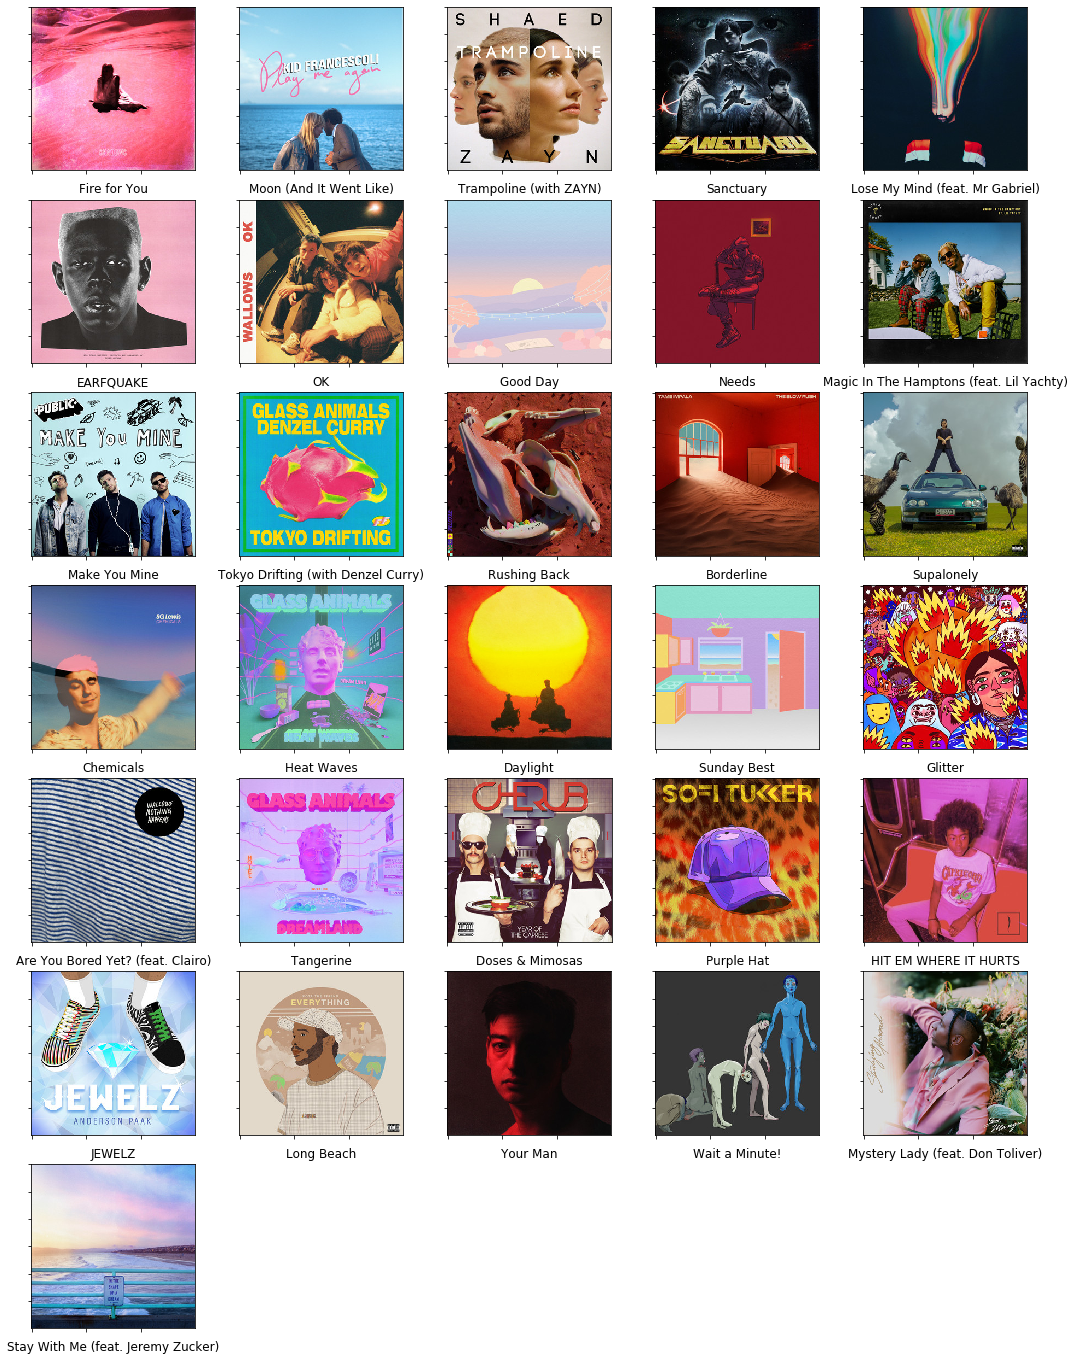

In [53]:
visualize_songs(playlist_GV)

At this point I have used the spotify API to get the above dataframe. I can now use this data frame to generate reccomendations for based on the summary of the data in the provided playlist.

In [54]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [55]:
complete_feature_set_playlist_vector_GV, complete_feature_set_nonplaylist_GV = generate_playlist_feature(complete_feature_set, playlist_GV, 1.09)

In [56]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [57]:
reccomendations = generate_playlist_recos(df_spotify, complete_feature_set_playlist_vector_GV, complete_feature_set_nonplaylist_GV)

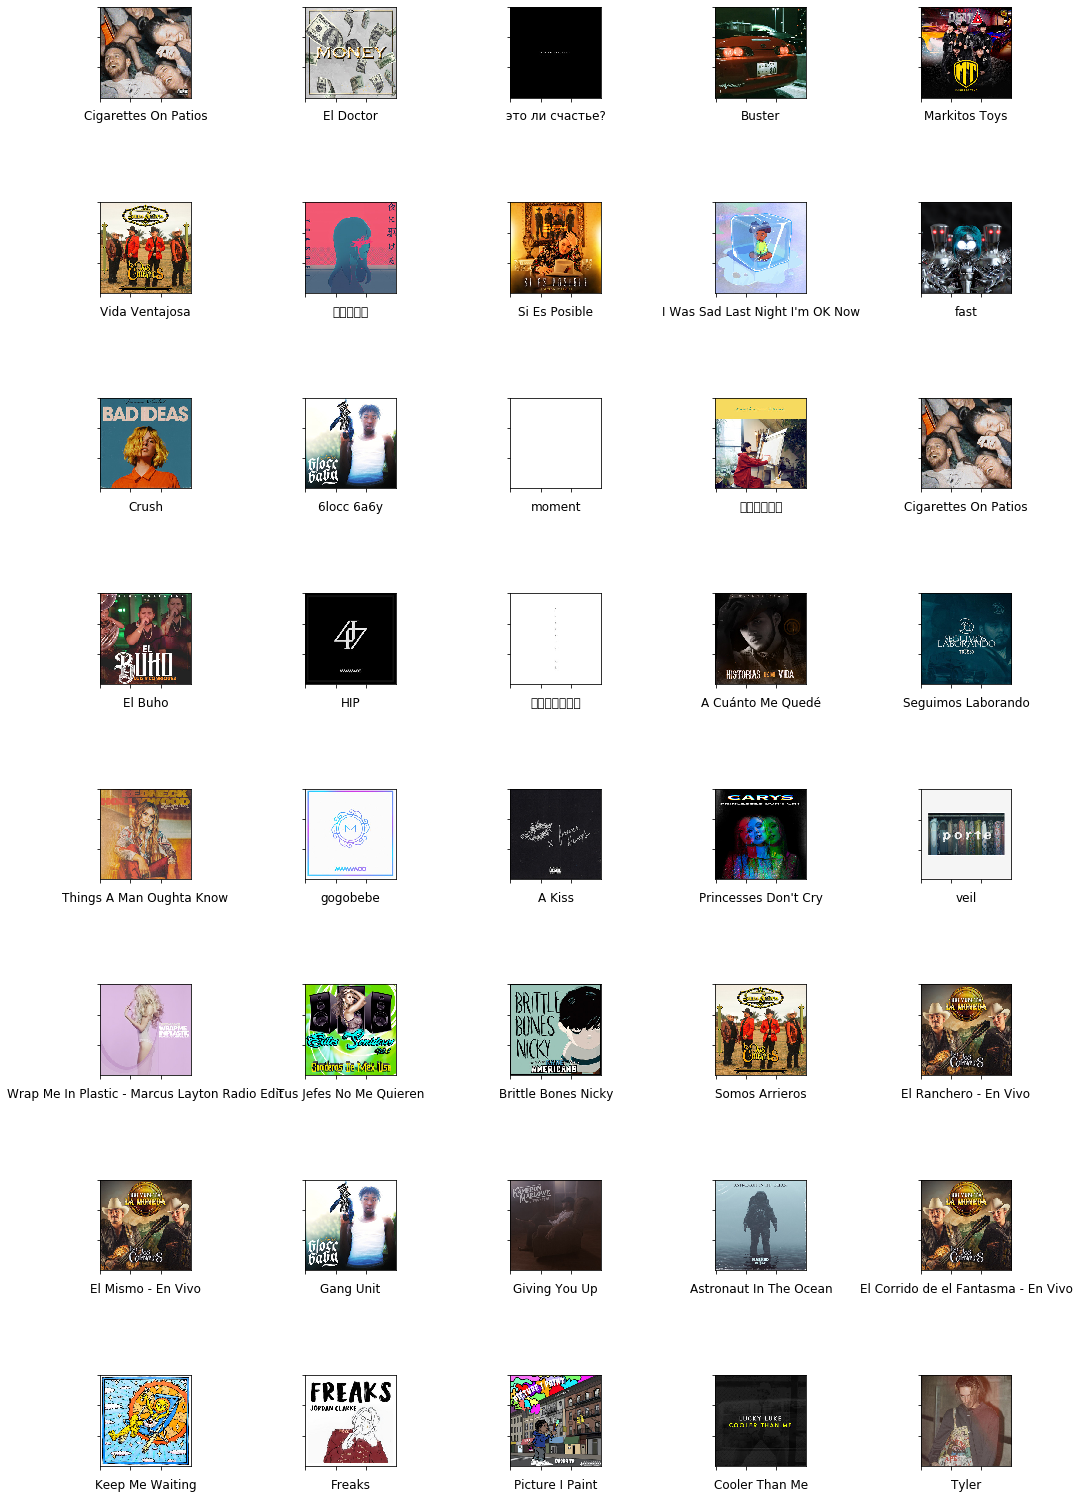

In [58]:
visualize_songs(reccomendations)